# 순환 신경망의 고급 사용법
* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가시킵니다(대신 계산 비용이 많이 듭니다).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

## 기온 예측 문제
* [날씨 시계열 데이터셋을 사용함](https://www.kaggle.com/pankrzysiu/weather-archive-jena)
* 이 데이터는 독일 예나 시에 있는 [막스 플랑크 생물지구화학 연구소](http://www.bgc-jena.mpg.de/wetter/)의 지상 관측소에서 수집한 것임
* 이 데이터셋에는 수년간에 걸쳐 (대기압, 온도, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있음 : 1일 144(6x24)개 데이터
* 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용함
* 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤임
* **최근 데이터(몇 일(10일)치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠음**

데이터 loading & 분석

In [30]:
import os

data_dir = './jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines), len(lines[0]), len(lines[2]))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551 101 101


420,551개 데이터 전체를 넘파이 배열로 바꿈

In [31]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))  # Date 정보 제외
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]  # Date 정보 제외
    float_data[i, :] = values

In [32]:
print(float_data.shape)
float_data[:2]

(420551, 14)


array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02]])

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

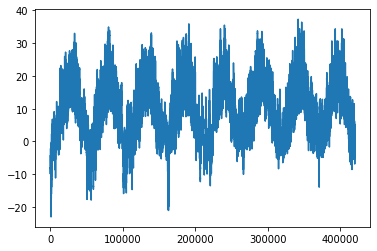

In [34]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

* 이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있음

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프임, 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있음

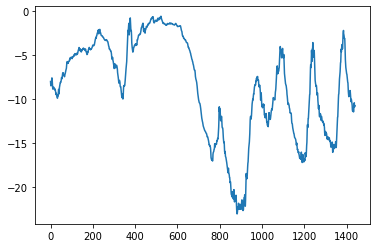

In [35]:
plt.plot(range(1440), temp[:1440])
plt.show()

## 문제 정의
* loopback 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링함
* 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측함
* 사용할 변수는 다음과 같음
<br>lookback = 1440 : 10일 전 데이터로 돌아감
<br>steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링함
<br>delay = 144 : 24시간이 지난 데이터가 타깃이 됨

### 데이터 전처리
* 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않음, 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다름(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값임). **각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꿀것임**
* **float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듬**, 이 데이터셋에 있는 샘플은 중복이 많음(샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷함). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠음. 

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리함. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산함

In [36]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 제너레이터 함수 만들기
이 함수는 `(samples, targets)` 튜플을 반복적으로 반환함. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열임
<br>이 제너레이터 함수는 다음과 같은 매개변수가 있음
* `data` : 위 코드에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용함
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정함
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠음

In [49]:
# for test by SOO
if 0:
    t_rows = np.random.randint(0+lookback, 200000, size=128)
    print(t_rows)

[ 79826 137203  88945 103102 155033  20722  13248 134612  54306  43646
 140087  89426  29032 198114 111661  54869 145472 191063  62854 143223
 162322 111814  51336 196504  54047 194790  79646  58192  23374 133427
 148428 103003 178257 112003 148121  59340 111613  32771 137408  19975
 116811 108508  14747  53682  19188 141695  36769 196129 180362 184251
 194101  72039  54721  99708 155073 111170 155794 172131 161001 111235
  66128 183547 182045  89313  47893   9584  56734 196156 161330  84273
 174188  41539  18213 144214 184396 185929  44144  82197  72455  65645
 164284 198555 180134 181649 192818 137504 158287 163630 102062 143378
  83887  53380  77666 159489  80189  41560 113136 167353  88345 183934
 188449  90439 193447 168515 103819 160315  19957 136461   5932  53935
 186325  57711 119109  54592 182709  58134 145839 185619 175809 125228
 171409 192134  82887 132594   6654 136771  43851  91706]


In [60]:
# for test by SOO
if 0:
    t_idx = range(79826 - lookback, 79826, step)
    l_idx = [idx for idx in t_idx]
    print(len(l_idx))  # 240
    print(l_idx)

240
[78386, 78392, 78398, 78404, 78410, 78416, 78422, 78428, 78434, 78440, 78446, 78452, 78458, 78464, 78470, 78476, 78482, 78488, 78494, 78500, 78506, 78512, 78518, 78524, 78530, 78536, 78542, 78548, 78554, 78560, 78566, 78572, 78578, 78584, 78590, 78596, 78602, 78608, 78614, 78620, 78626, 78632, 78638, 78644, 78650, 78656, 78662, 78668, 78674, 78680, 78686, 78692, 78698, 78704, 78710, 78716, 78722, 78728, 78734, 78740, 78746, 78752, 78758, 78764, 78770, 78776, 78782, 78788, 78794, 78800, 78806, 78812, 78818, 78824, 78830, 78836, 78842, 78848, 78854, 78860, 78866, 78872, 78878, 78884, 78890, 78896, 78902, 78908, 78914, 78920, 78926, 78932, 78938, 78944, 78950, 78956, 78962, 78968, 78974, 78980, 78986, 78992, 78998, 79004, 79010, 79016, 79022, 79028, 79034, 79040, 79046, 79052, 79058, 79064, 79070, 79076, 79082, 79088, 79094, 79100, 79106, 79112, 79118, 79124, 79130, 79136, 79142, 79148, 79154, 79160, 79166, 79172, 79178, 79184, 79190, 79196, 79202, 79208, 79214, 79220, 79226, 79232, 7

In [61]:
# 10일치 데이터를 생성함 (10일 데이터 1440개 중 1시간당 6개 데이터가 아니라 1개 데이터만 뽑음 --> 240개)
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets  ## samples.shape:(128,240,14), 240(=1440/6), targets.shape:(128,)

### 훈련용, 검증용, 테스트용 제너레이터 생성
* 각 제너레이터는 원본 데이터에서 다른 시간대를 사용함
* 훈련 제너레이터는 처음 200,000개 타임스텝을 사용
* 검증 제너레이터는 그 다음 100,000개를 사용
* 테스트 제너레이터는 나머지를 사용함

In [62]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

print('val_steps:', val_steps, 'test_steps:', test_steps)

val_steps: 769 test_steps: 930


## 상식 수준의 기준점(Baseline)
* 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있음(오늘 온도는 내일 온도와 비슷할 가능성이 높음)
* 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것임
* 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠음
<br>np.mean(np.abs(preds - targets))

다음은 평가를 위한 반복 루프임

In [63]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)  # samples.shape:(128,240,14), 240(=1440/6), targets.shape:(128,)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


* 출력된 MAE는 0.29임, 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않음
* 평균 절댓값 오차에 표준 편차를 곱하면 섭씨(°C)가 됨

In [64]:
0.29 * std[1]

2.5672247338393395

* 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됨. 평균 절댓값 오차가 상당히 큼!! 
* 이제 딥러닝 모델이 더 나은지 시도해 보자

## 기본적인 FNN 방법
* 다음 코드는 데이터를 펼쳐서 두 개의 `Dense` 층을 통과시키는 완전 연결 네트워크를 보여줌 
* 전형적인 회귀 문제이므로 마지막 `Dense` 층에 활성화 함수를 두지 않았음
* 손실 함수는 MAE임
* 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있음

In [65]:
float_data.shape

(420551, 14)

In [ ]:
from keras import backend as K
K.clear_session()

In [34]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))  # input_shape:(240,14)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.





Epoch 1/20





500/500 [==============================] - 14s 27ms/step - loss: 1.5498 - val_loss: 1.1356
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.6259 - val_loss: 0.6080
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3622 - val_loss: 0.3547
Epoch 4/20
500/500 [==============================] - 20s 41ms/step - loss: 0.3826 - val_loss: 0.3179
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3686 - val_loss: 0.3336
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2753 - val_loss: 0.3055 ETA: 0s - loss: 0.275
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2688 - val_loss: 0.4223
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2629 - val_loss: 0.3290
Epoch 9/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2590 - val_loss: 0.3394
Epoch 10/20
500/500 [==============================]

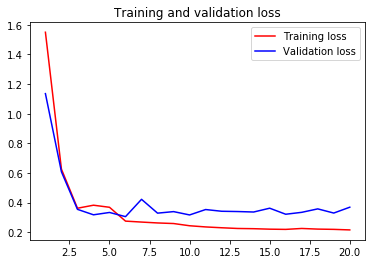

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못함
* 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않음 --> 모델 아키텍처가 적절치 않음 --> RNN 적용
* 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸음

##  `GRU` 층 적용
* GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듬
* GRU는 LSTM 만큼 표현 학습 능력이 높지는 않을 수 있음
* 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장함

In [66]:
from keras import backend as K
K.clear_session()

In [68]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))  # float_data.shape[-1]:14
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,    # input_shape:(240,14)
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 104s 209ms/step - loss: 0.3000 - val_loss: 0.2702
Epoch 2/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2824 - val_loss: 0.2689
Epoch 3/20
500/500 [==============================] - 110s 221ms/step - loss: 0.2764 - val_loss: 0.2652
Epoch 4/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2729 - val_loss: 0.2678
Epoch 5/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2700 - val_loss: 0.2671
Epoch 6/20
500/500 [==============================] - 95s 190ms/step - loss: 0.2641 - val_loss: 0.2677
Epoch 7/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2604 - val_loss: 0.2626
Epoch 8/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2562 - val_loss: 0.2665
Epoch 9/20
500/500 [==============================] - 100s 201ms/step - loss: 0.2502 - val_loss: 0.2704
Epoch 10/20
500/500 [==============================] - 107s 214ms/s

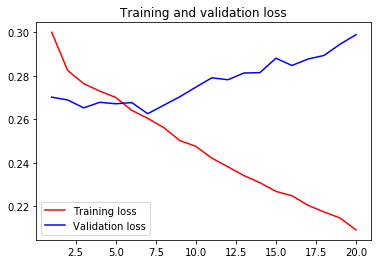

In [69]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다.

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
* 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 **동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용**해야 함
* GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 함(`순환 드롭 아웃 마스크`). 
* 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것임
* 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼침
* 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있음
<br>`dropout`은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값임. `recurrent_dropout`은 순환 상태의 드롭아웃 비율을 정함
* GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠음
* 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸리므로 에포크를 두 배 더 늘려 네트워크를 훈련하겠음

In [ ]:
from keras import backend as K
K.clear_session()

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,    # input_shape:(240,14)
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





500/500 [==============================] - 92s 183ms/step - loss: 0.3366 - val_loss: 0.2767
Epoch 2/40
500/500 [==============================] - 90s 181ms/step - loss: 0.3142 - val_loss: 0.2722
Epoch 3/40
500/500 [==============================] - 93s 186ms/step - loss: 0.3071 - val_loss: 0.2785
Epoch 4/40
500/500 [==============================] - 92s 184ms/step - loss: 0.3042 - val_loss: 0.2699
Epoch 5/40
500/500 [==============================] - 94s 188ms/step - loss: 0.2990 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 94s 188ms/step - loss: 0.2980 - val_loss: 0.2677
Epoch 7/40
500/500 [==============================] - 95s 190ms/step - loss: 0.2958 - val_loss: 0.2736
Epoch 8/40
500/500 [==============================] - 99s

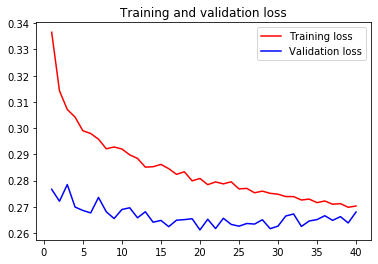

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 30번째 에포크까지 과대적합이 일어나지 않았음, 평가 점수는 안정적이지만 이전보다 더 나아지진 않았음

## 스태킹 순환 층
* 과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 함
* 네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가함
* 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법임
* 케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 함 <br>return_sequences=True로 지정하면 됨

In [70]:
from keras import backend as K
K.clear_session()

In [71]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,    # input_shape:(240,14)
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 306s 612ms/step - loss: 0.3350 - val_loss: 0.2755
Epoch 2/40
500/500 [==============================] - 308s 617ms/step - loss: 0.3109 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 294s 588ms/step - loss: 0.3060 - val_loss: 0.2744
Epoch 4/40
500/500 [==============================] - 253s 506ms/step - loss: 0.3018 - val_loss: 0.2661
Epoch 5/40
500/500 [==============================] - 256s 512ms/step - loss: 0.2982 - val_loss: 0.2664
Epoch 6/40
500/500 [==============================] - 255s 510ms/step - loss: 0.2959 - val_loss: 0.2680
Epoch 7/40
500/500 [==============================] - 286s 572ms/step - loss: 0.2907 - val_loss: 0.2662
Epoch 8/40
500/500 [==============================] - 348s 695ms/step - loss: 0.2878 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 291s 581ms/step - loss: 0.2839 - val_loss: 0.2657
Epoch 10/40
500/500 [==============================] - 266s 532m

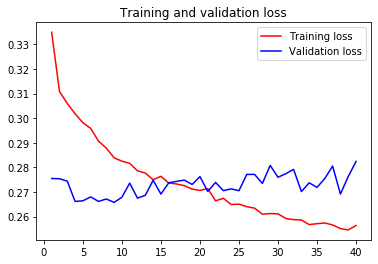

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상시켰지만 크지는 않음. 여기서 두 가지 결론을 얻을 수 있음
* 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있지만 적지 않은 계산 비용이 추가됨
* 층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있음

# 양방향 RNN 사용하기 - 온도 예측
* 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN 보다 훨씬 좋은 성능을 냄
* 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됨
* RNN은 특히 순서 또는 시간에 민감함. 즉, 입력 시퀀스의 타임스텝 순서대로 처리함. 
* 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버림. 이는 온도 예측과 같이 순서에 의미가 있는 문제에 잘 맞는 이유이기도 함
* 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용함. GRU나 LSTM 같은 RNN 두 개를 사용함
* 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합침
* 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있음

## Reverse RNN 사용하기 - 온도 예측
시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까?
* 실제 이렇게 해 보고 결과가 어떤지 확인해 보자 
* 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐임(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿈) --> 하나의 GRU 층을 가진 네트워크를 훈련함

In [73]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [74]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [75]:
from keras import backend as K
K.clear_session()

In [76]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 107s 215ms/step - loss: 0.4784 - val_loss: 0.4992
Epoch 2/20
500/500 [==============================] - 110s 220ms/step - loss: 0.4497 - val_loss: 0.4718
Epoch 3/20
500/500 [==============================] - 110s 221ms/step - loss: 0.4023 - val_loss: 0.4628
Epoch 4/20
500/500 [==============================] - 109s 219ms/step - loss: 0.3637 - val_loss: 0.4810
Epoch 5/20
500/500 [==============================] - 106s 213ms/step - loss: 0.3400 - val_loss: 0.4455
Epoch 6/20
500/500 [==============================] - 108s 216ms/step - loss: 0.3231 - val_loss: 0.4365
Epoch 7/20
500/500 [==============================] - 108s 216ms/step - loss: 0.3121 - val_loss: 0.4291
Epoch 8/20
500/500 [==============================] - 113s 226ms/step - loss: 0.3004 - val_loss: 0.4373
Epoch 9/20
500/500 [==============================] - 110s 220ms/step - loss: 0.2913 - val_loss: 0.4376
Epoch 10/20
500/500 [==============================] - 106s 213m

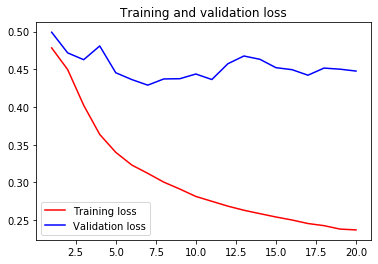

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮음. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 함
* 사실 이는 당연함. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억함. 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용함(상식 수준의 기준점이 꽤 강력한 이유임)
* 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않음. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않음

## Reverse LSTM 사용하기 - 영화평(IMDB)

In [78]:
from keras import backend as K
K.clear_session()

In [79]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 109s 5ms/step - loss: 0.4866 - acc: 0.7686 - val_loss: 0.3327 - val_acc: 0.8716
Epoch 2/10
20000/20000 [==============================] - 111s 6ms/step - loss: 0.3089 - acc: 0.8818 - val_loss: 0.4851 - val_acc: 0.7728
Epoch 3/10
20000/20000 [==============================] - 110s 5ms/step - loss: 0.2540 - acc: 0.9050 - val_loss: 0.3565 - val_acc: 0.8482
Epoch 4/10
20000/20000 [==============================] - 110s 6ms/step - loss: 0.2212 - acc: 0.9224 - val_loss: 0.4150 - val_acc: 0.8696
Epoch 5/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1956 - acc: 0.9328 - val_loss: 0.3574 - val_acc: 0.8804
Epoch 6/10
20000/20000 [==============================] - 113s 6ms/step - loss: 0.1722 - acc: 0.9403 - val_loss: 0.3944 - val_acc: 0.8636
Epoch 7/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.1605 - acc: 0.9455 - val_loss: 0.6296 - va

* 시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있음. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동함
* 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침함. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습함
* 이런 표현은 작업의 성능을 올리는 데 도움을 줌 --> 앙상블의 개념
* 양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킴. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냄

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

## 양방향 RNN 사용하기 - 영화평(IMDB)
* 케라스에서는 `Bidirectional` 층을 사용하여 양방향 RNN을 만듬
* 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받음
* `Bidirectional` 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듬. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리함

In [82]:
from keras import backend as K
K.clear_session()

In [83]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 201s 10ms/step - loss: 0.5617 - acc: 0.7166 - val_loss: 0.3887 - val_acc: 0.8558
Epoch 2/10
20000/20000 [==============================] - 208s 10ms/step - loss: 0.3371 - acc: 0.8690 - val_loss: 0.3056 - val_acc: 0.8812
Epoch 3/10
20000/20000 [==============================] - 216s 11ms/step - loss: 0.2717 - acc: 0.8985 - val_loss: 0.3352 - val_acc: 0.8824
Epoch 4/10
20000/20000 [==============================] - 237s 12ms/step - loss: 0.2288 - acc: 0.9180 - val_loss: 0.3130 - val_acc: 0.8792
Epoch 5/10
20000/20000 [==============================] - 259s 13ms/step - loss: 0.2100 - acc: 0.9244 - val_loss: 0.3479 - val_acc: 0.8860
Epoch 6/10
20000/20000 [==============================] - 224s 11ms/step - loss: 0.1819 - acc: 0.9367 - val_loss: 0.3486 - val_acc: 0.8860
Epoch 7/10
20000/20000 [==============================] - 209s 10ms/step - loss: 0.1680 - acc: 0.9392 - val_loss: 0.3

* 여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높음
* 이 모델은 조금 더 일찍 과대적합되는 것 같음. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문임
* 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합해 보임

## 양방향 RNN 사용하기 - 온도 예측 (적절치 않음)

In [84]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2931 - val_loss: 0.2730
Epoch 2/40
500/500 [==============================] - 144s 287ms/step - loss: 0.2741 - val_loss: 0.2706
Epoch 3/40
500/500 [==============================] - 144s 288ms/step - loss: 0.2666 - val_loss: 0.2674
Epoch 4/40
500/500 [==============================] - 143s 286ms/step - loss: 0.2627 - val_loss: 0.2733
Epoch 5/40
500/500 [==============================] - 168s 336ms/step - loss: 0.2553 - val_loss: 0.2740
Epoch 6/40
500/500 [==============================] - 172s 343ms/step - loss: 0.2485 - val_loss: 0.2745
Epoch 7/40
500/500 [==============================] - 143s 286ms/step - loss: 0.2448 - val_loss: 0.2797
Epoch 8/40
500/500 [==============================] - 143s 287ms/step - loss: 0.2399 - val_loss: 0.2802
Epoch 9/40
500/500 [==============================] - 144s 288ms/step - loss: 0.2339 - val_loss: 0.2809
Epoch 10/40
500/500 [==============================] - 152s 304m

* 이 네트워크는 일반 FNN 층과 비슷한 성능을 냄 --> 이런 작업에는 최근의 정보가 오래 전의 정보보다 훨씬 더 중요하기 때문